In [73]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
import pandas_datareader.data as web
import datetime
from random import randint

## Download data

In [74]:
a = np.array([range(20)])
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2020, 12, 31)
df = web.DataReader('^GSPC','yahoo',start,end)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,1478.000000,1438.359985,1469.250000,1455.219971,931800000,1455.219971
2000-01-04,1455.219971,1397.430054,1455.219971,1399.420044,1009000000,1399.420044
2000-01-05,1413.270020,1377.680054,1399.420044,1402.109985,1085500000,1402.109985
2000-01-06,1411.900024,1392.099976,1402.109985,1403.449951,1092300000,1403.449951
2000-01-07,1441.469971,1400.729980,1403.449951,1441.469971,1225200000,1441.469971


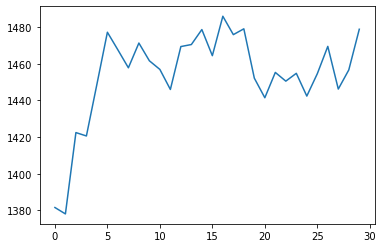

In [75]:
sp500 = df.Close.to_numpy()
sp500.shape
prices = sp500[100:130]
plt.plot(prices)

## The transformation
The Gramian Angular Field transformation
1. Scales down $x$, such that $$x_i \in [0,1]$$
2. Transforms $x$ to polar coordinates $$\theta_i = arccos(x_i)$$
3. Defines the output matrix as $$A_{ij} = cos(\theta_i + \theta_j)$$
Because the input is scaled down to $[0,1]$ (making the resulting angles $[0,\frac{\pi}{2}]$, their pairwise sums $[0,\pi]$), the mapping is bijective.

In [232]:
class GASF:
    
    def _scale(self, arr):
        return arr / arr.max()
    
    def _single_transform(self, x, y):
        return x*y*np.sqrt((1-x**2)*(1-y**2))
        
    def transform(self, arr):
        arr = self._scale(arr)
        X,Y = np.meshgrid(arr,arr)
        mat = self._single_transform(X,Y)
        return mat
    
    def _ex(self, x):
        return x*np.sqrt(1-x**2)
    
    def _inv_ex(self, A):
        return -np.sqrt((1-np.sqrt(1-4*A**2))/2)
    
    def _rev_one(self, A, B, C):
        return self._inv_ex(A*C/B)
    
    def _rev_next(self, A, prev):
        return A/self._ex(prev)
    
    def reverse(self, mat):
        n = mat.shape[0]
        l = [self._rev_one(mat[0,1], mat[1,2], mat[0,2])]
        for i in range(1,n):
            l.append(self._rev_next(mat[i-1,i], l[-1]))
            assert l[-1]>0
        return np.array(l)

class TrigGASF:
    
    def _scale(self, arr):
        return arr/arr.max()
    
    def transform(self, arr):
        arr = self._scale(arr)
        arr = np.arccos(arr)
        mat = np.add.outer(arr,arr)
        mat = np.cos(mat)
        return mat
    
    def reverse(self, mat):
        n = mat.shape[0]
        mat = np.arccos(mat)
        l = [(mat[0,1]+mat[0,2]-mat[1,2])/2]
        for i in range(1,n):
            l.append(mat[i-1,i] - l[-1])
        arr = np.array(l)
        return np.cos(arr)

g=TrigGASF()

Text(0.5, 1.0, 'reconstructed')

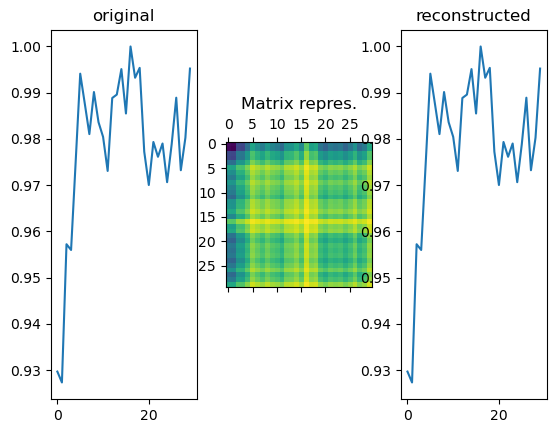

In [246]:
%matplotlib widget

fig, (ax1,ax2,ax3) = plt.subplots(1,3)
mat = g.transform(prices)
rev = g.reverse(mat)

ax1.plot(prices/prices.max())
ax1.set_title('original')
ax2.matshow(mat)
ax2.set_title('Matrix repres.')
ax3.plot(rev)
ax3.set_title('reconstructed')